<img src='images/img.jpeg'/>

# Stack Overflow: Tag Prediction

This ipython notebook is developed to predict as many tags as possible for questions posted on StackOverflow by applying differnt machine learning algorithm. A step by step analysis has been done on the data provided in the Kaggle. Based on the data provided, the machine learning model predicts the tags like(C#, Java etc) for each question.

<b>Data Source:</b><a href="https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/">https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction</a>


Data Dictionary
- Title,
- Body,
- Tags

With the provided data, we will first clean the data to get data in required format followed by exploratory data analysis.

Featurizing is one of the most important steps for building machine learning model. We will use `TF-IDF` to convert text into vector.

Since the dimension of input vector is high, we will be using linear multilevel classification algorithm to predict the tags.
We will be applying different multilevel classification model having optimized hyperparameter.  
- `Logistic Regression with GridSearch`
- `XgBoost classifier with Random search`

For testing the result we will use
- `Micro f1 scoore`
- `Macro f1 scoore`
- `Hamming loss`

__Objective: redict the Tag based on the text present in question posted using different classification technique with high precision and recall.__

This project is developed with the help of videos and basic code provided by appliedaicourse.com.

<h1>1 Data Overview </h1>

<a href = "https://stackoverflow.com/company" >Stackoverflow</a> is one of the largest and most trusted community platform for developers to learn, share their programming knowledge, and build their careers.
<br />
Every software engineer uses <a href = "https://stackoverflow.com/company" >Stackoverflow</a> in everyday life one way or another. Basically it is a question answering sites where many programmers, developers and learners intaract with each other.
<br />
As of Jan'2019 <a href = "https://stackoverflow.com/company" >Stackoverflow</a> have more then 50 million registered user and 19,000,000+ questions.

Stack Overflow provides tag to each of the questions asked based on the title and body of the questions, so that it will be easy to redirect this question to the developers who answered questions on related tags.This helps alot because the question is redirected to related subject matter expert, the chances of getting answer is much faster. 
<br /><br />
To know more about <a href = "https://stackoverflow.com/company" >Stackoverflow</a>,please visit the <a href = "https://stackoverflow.com/company" >link</a>.

<h1> 2 Exploratory Data Analysis </h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

<h2> 2.1 Data Loading and Cleaning </h2>

<h3>2.1.1 Using Pandas with SQLite to Load the data</h3>

In [2]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

<h3> 2.1.2 Counting the number of rows </h3>

In [3]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:02.542205


<h3>2.1.3 Checking for duplicates </h3>

In [4]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:02:45.152898


In [5]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [6]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [7]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [8]:
df_no_dup.dropna(inplace=True)

In [9]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:01.901917


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [10]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

In [11]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [12]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:14.816401


<h2> 2.2 Analysis of Tags </h2>

<h3> 2.2.1 Total number of unique tags </h3>

In [13]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [14]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206307
Number of unique tags : 42048


In [15]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 2.2.3 Number of times a tag appeared </h3>

In [16]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [17]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [18]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

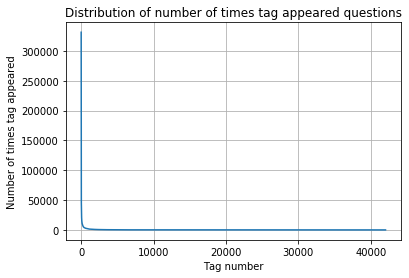

In [19]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

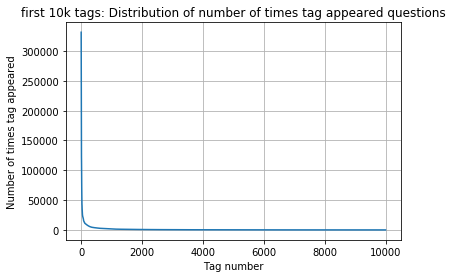

In [20]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

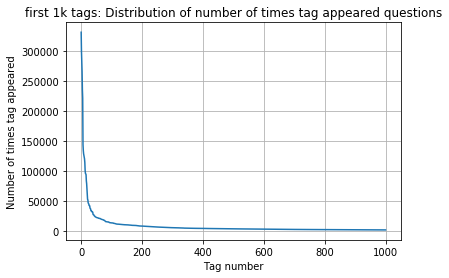

In [21]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

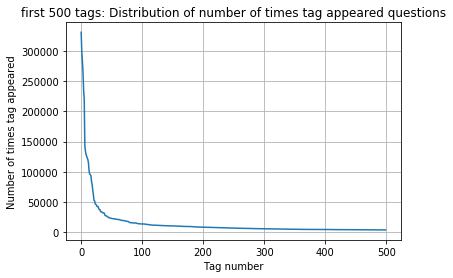

In [22]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

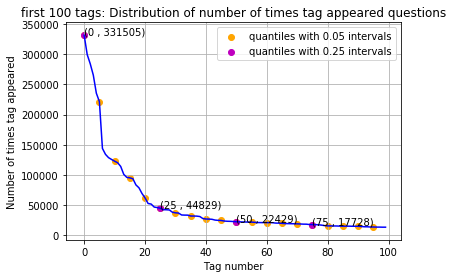

In [23]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [24]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 2.2.4 Tags Per Question </h3>

In [25]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206307 datapoints.
[3, 4, 2, 2, 3]


In [26]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899443


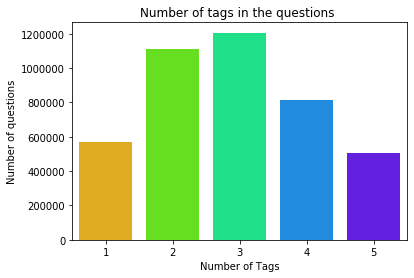

In [27]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>2.2.5 Most Frequent Tags </h3>

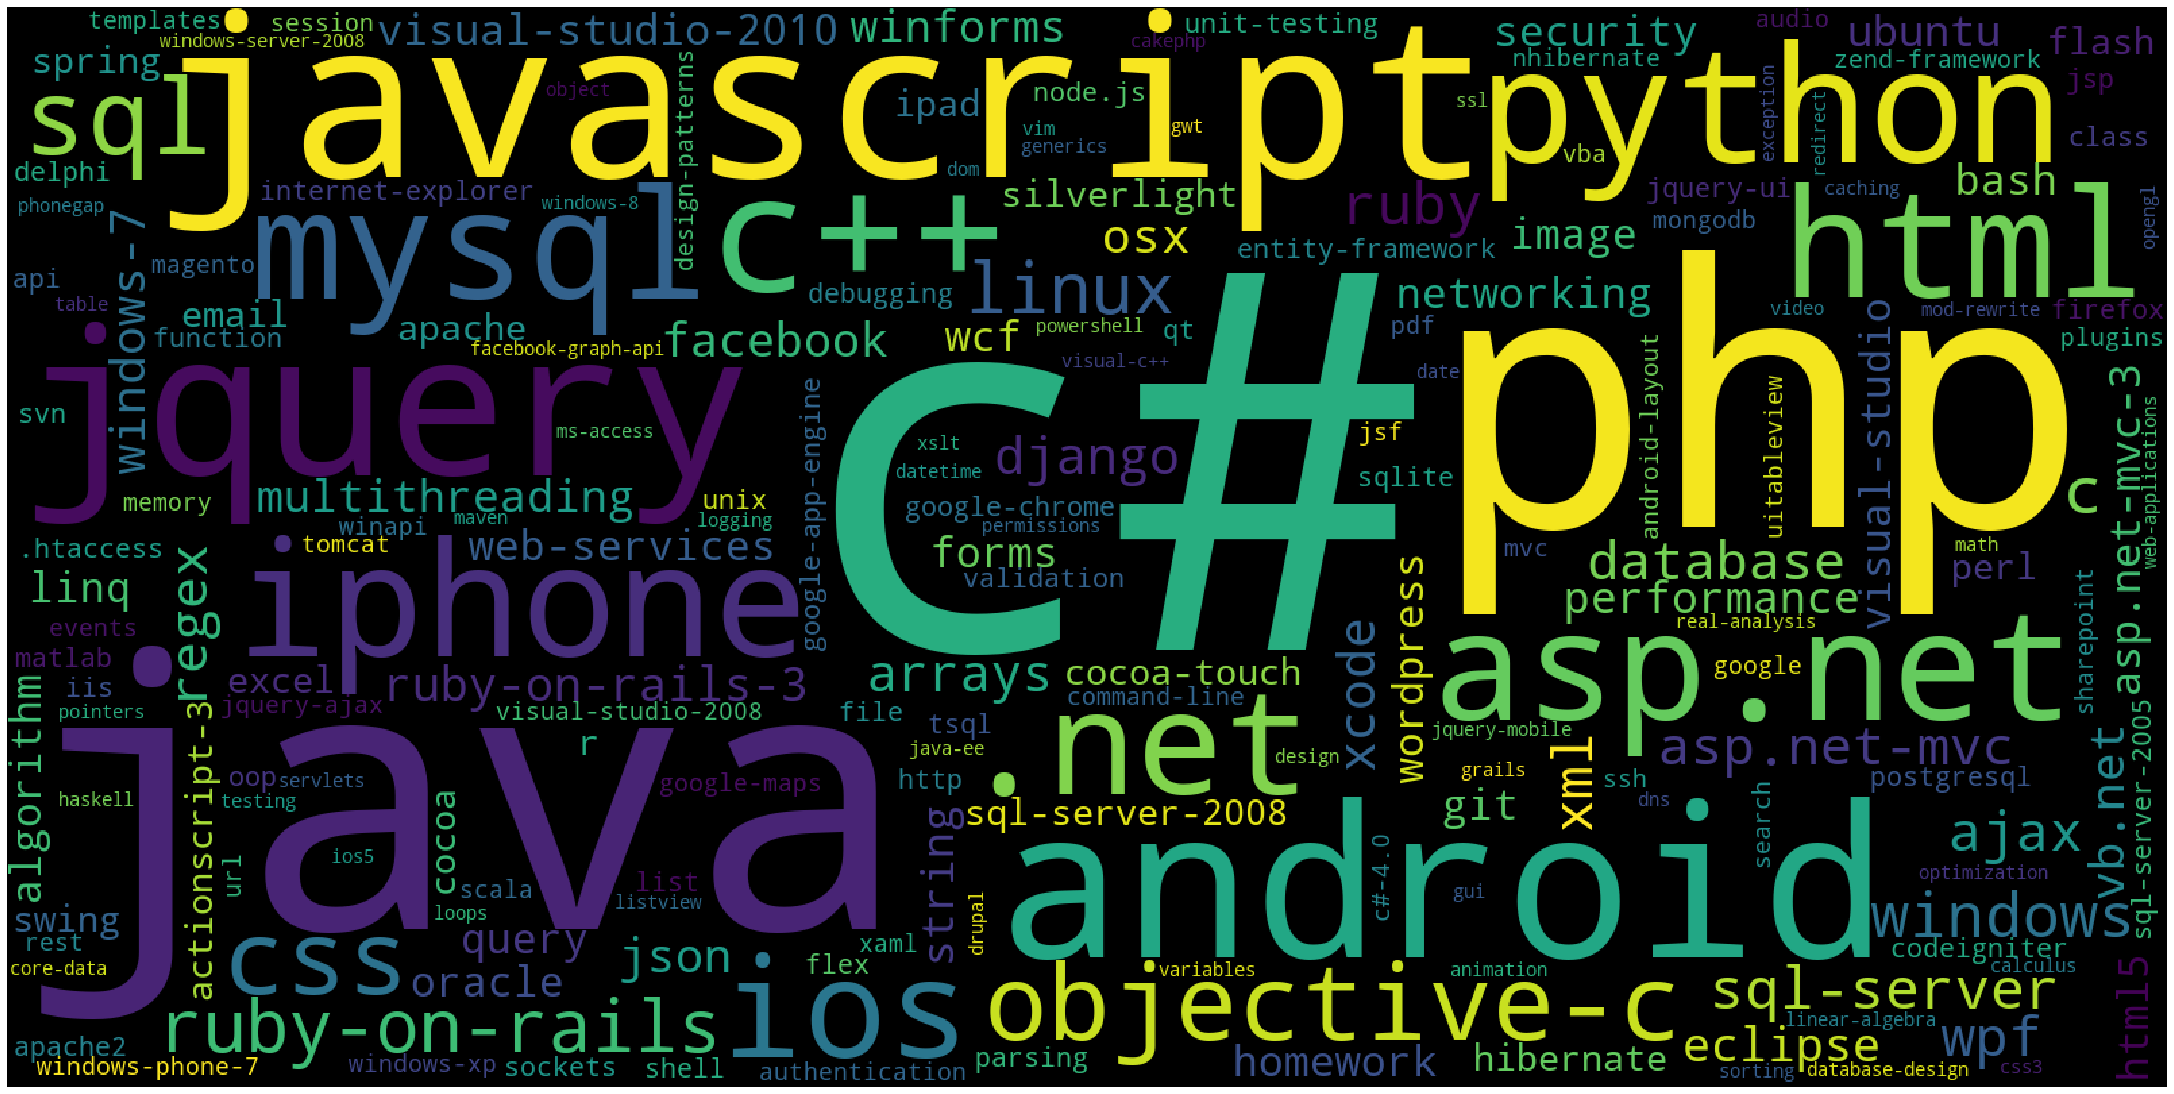

Time taken to run this cell : 0:00:03.020926


In [28]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 2.2.6 The top 20 tags </h3>

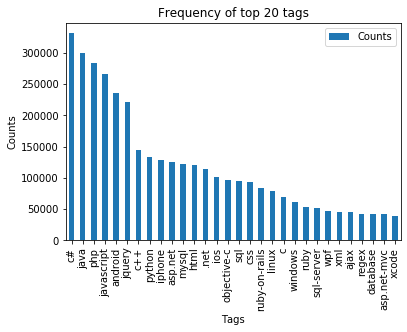

In [29]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 2.3 Cleaning and preprocessing of Questions </h3>

<h3> 2.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [30]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [31]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [32]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:08:15.000744


__ we create a new data base to store the sampled and preprocessed questions __

In [33]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1170
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:19:06.913169


In [34]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [35]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('android intent explicit handler id listact call edit form much like notepad tutori differ want call intent editoract class direct also send id right figur direct call intent send id general request edit match togeth',)
----------------------------------------------------------------------------------------------------
('addit linear independ vector say linear independ vector vector space field bbb linear independ vector possibl linear depend zero vector',)
----------------------------------------------------------------------------------------------------
('eclips code complet problem eclips match argument code complet follow exampl automat match stead show arg first option',)
----------------------------------------------------------------------------------------------------
('delphi tregexpr problem need get st string memo ad last result ie st get st st etc',)
----------------------------------------------------------------------------------------------

In [36]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [37]:
preprocessed_data.head()

,question,tags
0,obtain morphism sheav morphism presheav think ...,sheaf-theory
1,android intent explicit handler id listact cal...,android android-intent listactivity
2,addit linear independ vector say linear indepe...,linear-algebra
3,eclips code complet problem eclips match argum...,eclipse autocomplete
4,delphi tregexpr problem need get st string mem...,regex delphi


In [38]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999999
number of dimensions : 2


<h1>3. Machine Learning Models </h1>

<h2> 3.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [39]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [40]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [41]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

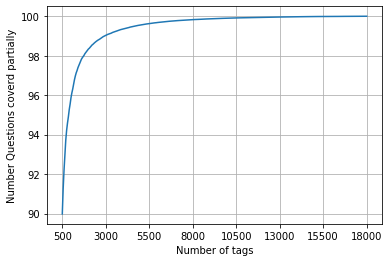

with  5500 tags we are covering  99.031 % of questions


In [42]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [43]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9685 out of  999999


In [44]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35505
number of tags taken : 5500 ( 15.490775947049713 %)


__ We consider top 15% tags which covers  99% of the questions __

<h2>3.2 Split the data into test and train (80:20) </h2>

In [45]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [46]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 5500)
Number of data points in test data : (200000, 5500)


<h2>3.3 Featurizing data </h2>

In [47]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:45.736830


In [48]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799999, 88143) Y : (799999, 5500)
Dimensions of test data X: (200000, 88143) Y: (200000, 5500)


<h2> 3.4 Applying Logistic Regression with OneVsRest Classifier </h2>

In [49]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.082485
macro f1 score : 0.09787299708328737
micro f1 scoore : 0.3757000983175547
hamming loss : 0.00041100727272727275
Precision recall report :
               precision    recall  f1-score   support

           0       0.63      0.22      0.33     15759
           1       0.79      0.43      0.56     14304
           2       0.82      0.55      0.66     13485
           3       0.76      0.43      0.55     12524
           4       0.94      0.76      0.84     11168
           5       0.85      0.65      0.74     10321
           6       0.70      0.30      0.42      6837
           7       0.87      0.59      0.70      6398
           8       0.71      0.38      0.50      6235
           9       0.78      0.41      0.54      5982
          10       0.84      0.60      0.70      5837
          11       0.53      0.19      0.28      5633
          12       0.52      0.10      0.16      5352
          13       0.60      0.24      0.34      4999
          14       0.63      0

In [50]:
# For training the above model, it took me 6 hours so saving the model in pickle file.
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl') 

C:\Users\nikz1\Anaconda3\envs\quora\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['lr_with_equal_weight.pkl']

<h2> 3.5 Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [51]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [52]:
read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


<h3> 3.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description which is not in code</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>  
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [53]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:12:11.773669


In [54]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [55]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

__ Saving Preprocessed data to a Database __

In [56]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [57]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [58]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [59]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [60]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

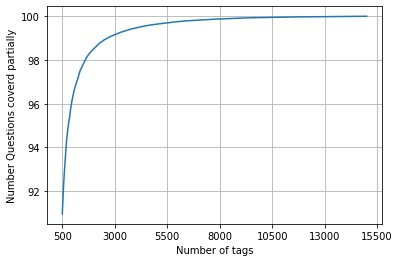

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [61]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [62]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [63]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [64]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


<h3> 3.5.2 Featurizing data with TfIdf vectorizer </h3>

In [65]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:02:36.440894


In [66]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (100000, 500)


<h3> 3.5.3 Finding Hyper Parameter alpha </h3>

In [67]:
alp = [10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]

In [1]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from collections import Counter

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for a in alp:  #alp = k
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=a, penalty='l2'))

    scores = cross_val_score(classifier, x_train_multilabel, y_train, cv=5, scoring='f1_micro')
    cv_scores.append(scores.mean())

f_score = [x for x in cv_scores]

# determining best alpha
optimal_alpha = alp[f_score.index(max(f_score))]
print('\nThe optimal value of alpha is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(alp, f_score)

for xy in zip(alp, np.round(f_score,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of Alpha')
plt.ylabel('F1_Score')
plt.show()


Best alpha: 0.001


In [69]:
print("Since higest F1 score is for alpha=0.001")

Since higest F1 score is for alpha=0.001


<h3> 3.5.3 Applying Logistic Regression with OneVsRest Classifier and alpha=0.001 </h3>

In [85]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l1'), n_jobs=-1)
classifier1.fit(x_train_multilabel, y_train)
predictions1 = classifier1.predict(x_test_multilabel)



In [86]:
print("accuracy :",metrics.accuracy_score(y_test,predictions1))
print("macro f1 score :",metrics.f1_score(y_test, predictions1, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions1, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions1))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions1))

accuracy : 0.23689
macro f1 score : 0.3345880028063686
micro f1 scoore : 0.44914522124384765
hamming loss : 0.00278012
Precision recall report :
               precision    recall  f1-score   support

           0       0.94      0.64      0.77      5519
           1       0.68      0.27      0.38      8190
           2       0.81      0.38      0.51      6529
           3       0.81      0.43      0.56      3231
           4       0.81      0.41      0.54      6430
           5       0.82      0.34      0.48      2879
           6       0.87      0.50      0.63      5086
           7       0.88      0.54      0.67      4533
           8       0.60      0.13      0.22      3000
           9       0.81      0.53      0.64      2765
          10       0.59      0.16      0.25      3051
          11       0.70      0.33      0.45      3009
          12       0.64      0.25      0.36      2630
          13       0.71      0.23      0.35      1426
          14       0.90      0.53      0.67

<h3> 3.5.3 Applying Linear SVM with OneVsRest Classifier and C=1 </h3>

In [87]:
classifier_2 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
prediction2 = classifier_2.predict(x_test_multilabel)
print("completed")

completed


In [88]:
start = datetime.now()
print("accuracy :",metrics.accuracy_score(y_test,prediction2))
print("macro f1 score :",metrics.f1_score(y_test, prediction2, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, prediction2, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,prediction2))
print("Precision recall report :\n",metrics.classification_report(y_test, prediction2))

print("Time taken to run this cell :", datetime.now() - start)

accuracy : 0.24724
macro f1 score : 0.2631716397718259
micro f1 scoore : 0.43151522305506607
hamming loss : 0.00269696
Precision recall report :
               precision    recall  f1-score   support

           0       0.95      0.67      0.79      5519
           1       0.70      0.22      0.33      8190
           2       0.84      0.35      0.50      6529
           3       0.82      0.41      0.55      3231
           4       0.85      0.37      0.51      6430
           5       0.82      0.35      0.50      2879
           6       0.87      0.52      0.65      5086
           7       0.89      0.54      0.68      4533
           8       0.62      0.14      0.23      3000
           9       0.83      0.52      0.64      2765
          10       0.63      0.01      0.02      3051
          11       0.78      0.31      0.44      3009
          12       0.74      0.22      0.34      2630
          13       0.72      0.18      0.29      1426
          14       0.90      0.57      0.70

# 4 Consclusion

1. One of the most important feature while solving this problem is `Tag`
2. Although there are more than 50000 tags, 5000 tags contains 99% of question, so we can use only 5k tags to build our model. For small PC we can choose 500 tags because it covers 90% of question.
3. KNN model fails in small PC because of out of memory
4. Since dimension of our input vector is very high, we know linear model will work better. So, we build three models which is given as below. 
    - OneVsRest SGD classifier with log loss which is a `Logistic Regression with optimized hyperparameter(alpha=0.001)` having Micro-Averaged `F1-Score=0.377` and `Hamming loss = 0.0005`
    - OneVsRest SGD classifier with log loss which is a `Logistic Regression  with hyperparameter(alpha=0.0001)` having `Micro-Averaged F1-Score=0.433` and `Hamming loss = 0.0005`
    - OneVsRest SGD classifier with hinge loss which is a `Linear SVC with optimized hyperparameter` having `Micro-Averaged F1-Score=0.433` and `Hamming loss = 0.0005`
